<a href="https://colab.research.google.com/github/romanescobar/Challenge-Telecom-X/blob/main/FlightOnTime_Modelado%202.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score

### CARGA DE DATOS

In [ ]:
# DATASET
# Airline:  aerolínea
# Flight:   tipo de aeronave
# Time:     hora de salida en minutos (desde medianoche)
# Length:   tiempo de vuelo en minutos
url = 'https://raw.githubusercontent.com/Sts87/FlightOnTime/refs/heads/main/data/Airlines.csv'
df = pd.read_csv(url)

### FUNCIONES

In [ ]:
def ancho_bin(df, columna):
    q1, q3 = np.percentile(df[columna], [25, 75])
    iqr = q3 - q1
    ancho = 2 * iqr * np.power(len(df[columna]), -1/3)
    return ancho

### INSPECCIÓN INICIAL

In [ ]:
# VISUALIZAR COLUMNAS Y DATOS DE DATASET ORIGINAL
# -Cada fila representa un vuelo
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [ ]:
# ESTRUCTURA DEL DATASET
# -Vuelos: 539k
# -Campos: 9
df.shape

(539383, 9)

In [ ]:
# PROPIEDADES DE LOS CAMPOS
# -Los tipos de datos están correctamente asignados (enteros, cadenas)
# -No existen nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


### LIMPIEZA DE DATOS

In [ ]:
# ELIMINAR COLUMNA ID
# -No es necesario tener el identificador único en el dataset
df.drop('id', axis=1, inplace=True)

In [ ]:
# VALIDAR VALORES EN BLANCO
# -No se encontraron columnas con valores vacios
(df == '').sum()

,0
Airline,0
Flight,0
AirportFrom,0
AirportTo,0
DayOfWeek,0
Time,0
Length,0
Delay,0


### ANÁLISIS ESTADÍSTICO

In [ ]:
# VARIABLES NÚMERICAS
# -Las variables Time y Length tienen comportamiento normal aparentemente
df[['Time', 'Length']].describe().round(1)

,Time,Length
count,539383.0,539383.0
mean,802.7,132.2
std,278.0,70.1
min,10.0,0.0
25%,565.0,81.0
50%,795.0,115.0
75%,1035.0,162.0
max,1439.0,655.0


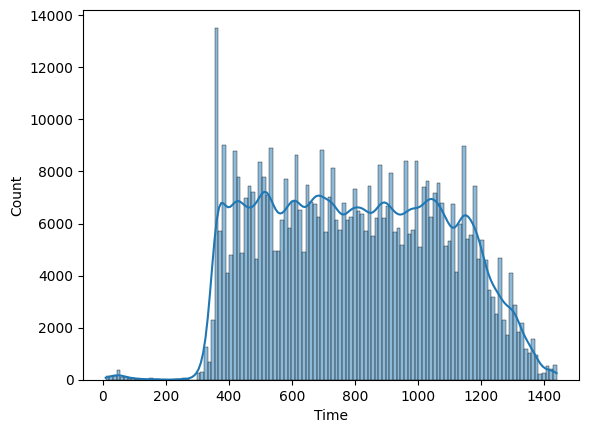

In [ ]:
# Time
# -Tiene un rango con distribucion uniforme desde 400 hasta 1000
# -Esto indica que los horarios de salida son constantes en este rango
anchobin = ancho_bin(df, 'Time')
sns.histplot(data=df, x='Time', kde=True, binwidth=anchobin)
plt.show()

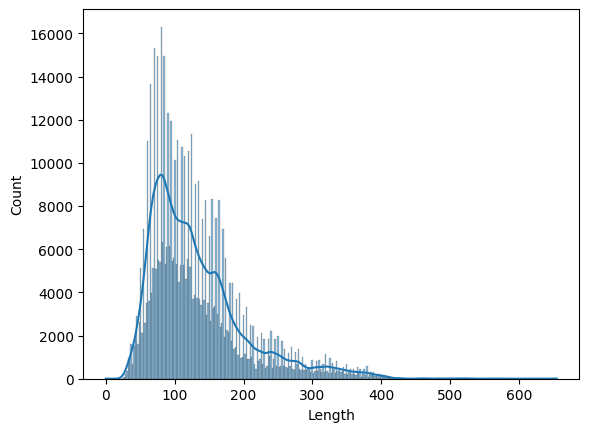

In [ ]:
# Length
# -Tiene distribucion que se asemeja a una normal
# -Esto indica que la duración de vuelo está concentrada en el rango de 50 - 180 minutos
anchobin = ancho_bin(df, 'Length')
sns.histplot(data=df, x='Length', kde=True, binwidth=anchobin)
plt.show()

In [ ]:
# VARIABLES CATEGÓRICAS
# -La variable Airline tiene 18 clases, lo cual indica que está atomizada
# -Las variables AirportFrom y AirportTo tienen 293, están muy atomizadas
df.describe(include='object')

,Airline,AirportFrom,AirportTo
count,539383,539383,539383
unique,18,293,293
top,WN,ATL,ATL
freq,94097,34449,34440


### PROPORCIÓN DE CLASES DE LA VARIABLE OBJETIVO

In [ ]:
# IDENTIFICAR SI HAY DESBALANCEO EN LA VARIABLES OBJETIVO (DELAY)
# -No hay desbalanceo: proporcion 55-45%
df_cnt = df['Delay'].value_counts()
df_pct = df['Delay'].value_counts(normalize=True).round(2) * 100

df_delay = pd.concat([df_cnt, df_pct], axis=1)
df_delay

,count,proportion
Delay,,
0,299119,55.0
1,240264,45.0


### NUEVAS VARIABLES

In [ ]:

# Nuevas variables candidatas:
# DateHour (hh:mm)
df['DateHour'] = df['Time'].apply(lambda x: str(x // 60).zfill(2) + ":" + str(x % 60).zfill(2))
df['DateHour'] = pd.to_datetime(df['DateHour'], format="%H:%M")


# Nuevas variables candidatas:
# Hour: hora en formato hh:mm
df['Hour'] = df['Time'].apply(lambda x: str(x // 60).zfill(2) + ":" + str(x % 60).zfill(2))
df['Hour'] = pd.to_datetime(df['Hour'], format="%H:%M")

# Time of day: Momento del dia de la salida del vuelo
# -Early morning: [0AM  - 6AM]
# -Morning:       <6AM  - 12PM]
# -Early morning: <12PM - 6PM]
# -Early morning: <6PM  - 12AM>
clases = [0, 360, 720, 1080, 1440]
labels = ['Early morning', 'Morning', 'Afternoon', 'Night']
df['TimeDay'] = pd.cut(x=df['Time'], bins=clases, labels=labels, include_lowest=True)

# Duration: Duracion del vuelo
# -Short:  [0min   - 90min]
# -Medium: <90min  - 180min]
# -Long:   [180min - 960min]
clases = [0, 90, 180, 960]
labels = ['Short', 'Medium', 'Long']
df['Duration'] = pd.cut(x=df['Length'], bins=clases, labels=labels, include_lowest=True)

### ANALISIS DESCRIPTIVO

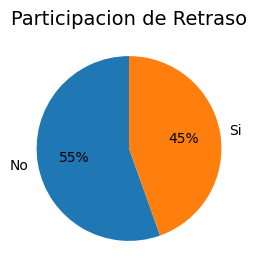

In [ ]:
# Retraso: 55% a tiempo, 45% retraso
plt.figure(figsize=(4, 3))
plt.pie(df['Delay'].value_counts(), labels=['No','Si'], autopct='%1.0f%%', startangle=90)
plt.title('Participacion de Retraso', fontsize=14)
plt.show()

In [ ]:
df2 = df.groupby(['DayOfWeek', 'Delay'])['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('DayOfWeek')['NumFlights'].transform(lambda x: x / x.sum())
df2

,DayOfWeek,Delay,NumFlights,PctFlights
0,1,0,38739,0.532356
1,1,1,34030,0.467644
2,2,0,39427,0.552663
3,2,1,31913,0.447337
4,3,0,47492,0.529182
5,3,1,42254,0.470818
6,4,0,50201,0.548975
7,4,1,41244,0.451025
8,5,0,49733,0.583392
9,5,1,35515,0.416608


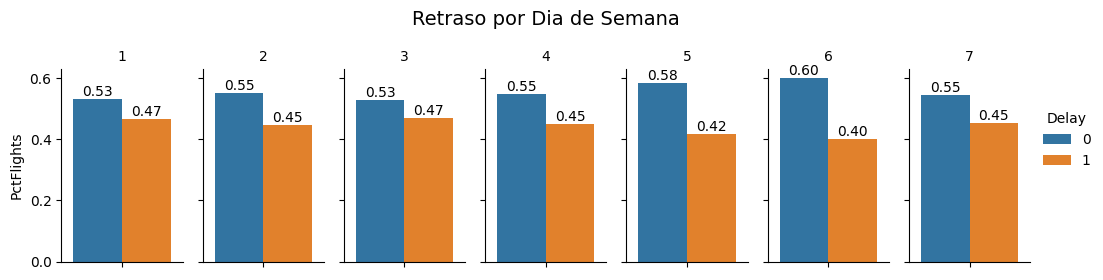

In [ ]:
# Retraso por Dia de semana:
# -Dias 5 y 6 tienen menores retrasos
df2 = df.groupby(['DayOfWeek', 'Delay'])['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('DayOfWeek')['NumFlights'].transform(lambda x: x / x.sum())

g = sns.catplot(
       data=df2, hue="Delay", y="PctFlights", col="DayOfWeek",
       kind="bar", height=2.5, aspect=.6
    )

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')


g.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
g.fig.suptitle("Retraso por Dia de Semana", y=1.1, fontsize=14)

plt.show()

#📄Informe final: Análisis de Datos para FlightOnTime

## Informe Conclusivo del Análisis de Datos

El análisis exploratorio de los datos de vuelos ha revelado varias características clave que son relevantes para el modelado predictivo del retraso de vuelos:

### 1. Estructura y Calidad de los Datos:
*   El dataset original contenía `539,383` registros y `9` columnas.
*   La columna `id` fue eliminada ya que no aportaba información relevante para el análisis o modelado.
*   Se confirmó la ausencia de valores nulos o cadenas vacías después de la limpieza inicial, asegurando la integridad de los datos.

### 2. Variables Numéricas Clave:
*   **`Time` (hora de salida):** Varía de 10 a 1439 minutos (00:10 a 23:59), con una media de 802.7 minutos (aproximadamente 13:22). Esta variable fue utilizada para crear la `Hour` y `TimeDay`.
*   **`Length` (duración del vuelo):** Varía de 0 a 655 minutos, con una media de 132.2 minutos. Los valores de 0 minutos fueron identificados y serán manejados en el preprocesamiento del modelado. Esta variable fue utilizada para crear la `Duration`.

### 3. Variables Categóricas Clave:
*   **`Airline`:** Existen `18` aerolíneas únicas. La aerolínea 'WN' (Southwest Airlines) es la más frecuente.
*   **`AirportFrom` y `AirportTo`:** Hay `293` aeropuertos de origen y destino únicos, con 'ATL' (Hartsfield-Jackson Atlanta) siendo el más frecuente para ambos.
*   **`DayOfWeek`:** Es una variable numérica que representa el día de la semana. Se observó que los días 5 (viernes) y 6 (sábado) tienen consistentemente menores porcentajes de vuelos retrasados en comparación con otros días, lo cual es una característica importante para el modelado.

### 4. Balance de la Variable Objetivo (`Delay`):
*   La variable objetivo `Delay` (retraso) presenta un balance aceptable: aproximadamente `55%` de los vuelos no tienen retraso (0) y `45%` sí lo tienen (1).
*   Este balance indica que no hay un desequilibrio severo de clases, lo que reduce la necesidad de técnicas de sobremuestreo o submuestreo agresivas en la fase de modelado, aunque se podría considerar `class_weight='balanced'` en los modelos para asegurar un buen rendimiento en ambas clases.

### 5. Nuevas Variables Creadas:
*   **`Hour`:** Representación horaria (`HH:MM`) derivada de `Time`, potencialmente útil para capturar patrones horarios de retrasos.
*   **`TimeDay`:** Categorización del momento del día (`Early morning`, `Morning`, `Afternoon`, `Night`) basada en `Time`, que podría capturar diferentes dinámicas de tráfico.
*   **`Duration`:** Categorización de la duración del vuelo (`Short`, `Medium`, `Long`) basada en `Length`, que podría reflejar el impacto de la duración en el retraso.

### Conclusiones para el Modelado:
*   Las variables `Airline`, `AirportFrom`, `AirportTo`, `DayOfWeek`, `Time`, `Length`, `Hour`, `TimeDay` y `Duration` son candidatas clave para la predicción de retrasos.
*   La variable `DayOfWeek` muestra una clara relación con el retraso, lo que la convierte en un predictor valioso.
*   La granularidad de `AirportFrom` y `AirportTo` (293 categorías) sugiere la necesidad de técnicas de codificación que manejen alta cardinalidad, como la codificación por media (Mean Encoding) o One-Hot Encoding con manejo de baja frecuencia, para evitar el problema de la dimensionalidad.
*   El balance de la variable objetivo es favorable, pero la exploración de métricas como `F1-score` y `Recall` será crucial para evaluar el rendimiento del modelo en la identificación de retrasos, más allá de la precisión general.
*   La creación de `Hour`, `TimeDay`, y `Duration` puede capturar patrones temporales y de duración que las variables originales `Time` y `Length` no expresarían directamente a un modelo lineal. Estas variables ya han sido incorporadas en la segunda fase de modelado, junto con la eliminación de `Time` y `Flight` por su menor correlación o alta cardinalidad, respectivamente.

# Modelado de Datos 2

In [ ]:
url = 'https://raw.githubusercontent.com/Sts87/FlightOnTime/refs/heads/feature/model-training/Airlines_processed.csv'
data = pd.read_csv(url)
# Revisar encoding de DayOfWeek con correlacion de calor con delay
# Flight considerarlo en el modelado, hacer dos modelos para ver si influye y escoger

In [ ]:
data.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Hour,TimeDay,Duration
0,CO,269,SFO,IAH,3,15,205,1,0.250000,Early morning,Long
1,US,1558,PHX,CLT,3,15,222,1,0.250000,Early morning,Long
2,AA,2400,LAX,DFW,3,20,165,1,0.333333,Early morning,Medium
3,AA,2466,SFO,DFW,3,20,195,1,0.333333,Early morning,Long
4,AS,108,ANC,SEA,3,30,202,0,0.500000,Early morning,Long


Text(0.5, 1.0, 'Mapa de Calor de Correlaciones')

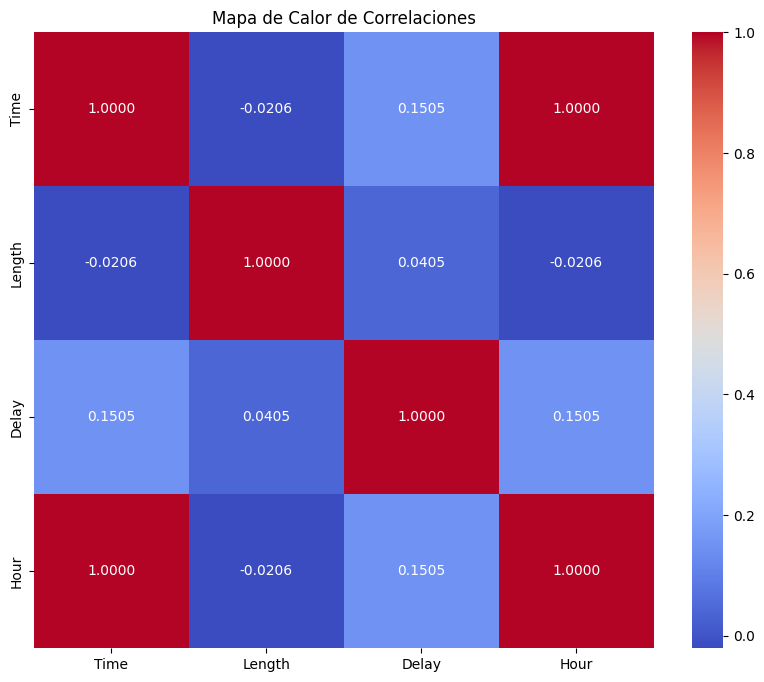

In [ ]:
numerico = ['Time', 'Length', 'Delay', 'Hour']
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerico].corr(), annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Mapa de Calor de Correlaciones')

## PREPARACIÓN DEL DATAFRAME

In [ ]:
eliminar = ['Flight', 'Time', 'TimeDay', 'Duration']
data.drop(columns=eliminar, inplace=True)
data.head()

,Airline,AirportFrom,AirportTo,DayOfWeek,Length,Delay,Hour
0,CO,SFO,IAH,3,205,1,0.250000
1,US,PHX,CLT,3,222,1,0.250000
2,AA,LAX,DFW,3,165,1,0.333333
3,AA,SFO,DFW,3,195,1,0.333333
4,AS,ANC,SEA,3,202,0,0.500000


In [ ]:
# Configuración
RANDOM_STATE = 42

In [ ]:
# Se selecciona los valores mayores que 0
data = data[data['Length']>0]

# Agrupación de aerolineas con una distribución menor de 0.05
vc = data['Airline'].value_counts(normalize=True)
cambiar_nombre = vc[vc<0.05].index

data['Airline'] = data['Airline'].replace(cambiar_nombre, 'OTHERS')

## PREPROCESAMIENTO

In [ ]:
data = data.sample(20000, random_state=RANDOM_STATE)
data.Airline.value_counts(normalize=True)*100

,proportion
Airline,
OTHERS,24.250
WN,17.610
DL,11.325
OO,9.295
AA,8.540
MQ,6.545
US,6.240
XE,5.800
EV,5.325


In [ ]:
X = data.drop(columns='Delay')
y = data['Delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, shuffle=True , stratify=y)

train_temp = X_train.copy()
train_temp['Delay'] = y_train

# Mapeo de la media de cada aeropuerto
from_map = train_temp.groupby('AirportFrom')['Delay'].mean().to_dict()
to_map = train_temp.groupby('AirportTo')['Delay'].mean().to_dict()

# Mapeo global de la media
global_mean = y_train.mean()

# Mapeos aplicados X_train
X_train['AirportFrom'] = X_train['AirportFrom'].map(from_map).fillna(global_mean).astype(float)
X_train['AirportTo'] = X_train['AirportTo'].map(to_map).fillna(global_mean).astype(float)

# Mapeos aplicados X_test
X_test['AirportFrom'] = X_test['AirportFrom'].map(from_map).fillna(global_mean).astype(float)
X_test['AirportTo'] = X_test['AirportTo'].map(to_map).fillna(global_mean).astype(float)

cat_cols = ['Airline', 'DayOfWeek']
num_cols = ['Length', 'Hour', 'AirportFrom', 'AirportTo']

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False
        ), cat_cols),
        ("num", RobustScaler(), num_cols),
    ],
    remainder="drop"
)

pipeline_lr = Pipeline([
    ('pre', preprocess),
    ('model', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000, n_jobs=-1))
])

pipeline_rf = Pipeline([
    ('pre', preprocess),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', max_depth=20, n_jobs=-1))
])

## ENTRENAMIENTO DE MODELOS

In [ ]:
# Logistic Regression y Random Forest

pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)

In [ ]:
print("--- LOGÍSTICA ---")
print(classification_report(y_test, y_pred_lr))
print("\n--- RANDOM FOREST ---")
print(classification_report(y_test, y_pred_rf))

--- LOGÍSTICA ---
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      2770
           1       0.56      0.57      0.57      2230

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000


--- RANDOM FOREST ---
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      2770
           1       0.58      0.52      0.55      2230

    accuracy                           0.62      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.62      0.62      0.62      5000



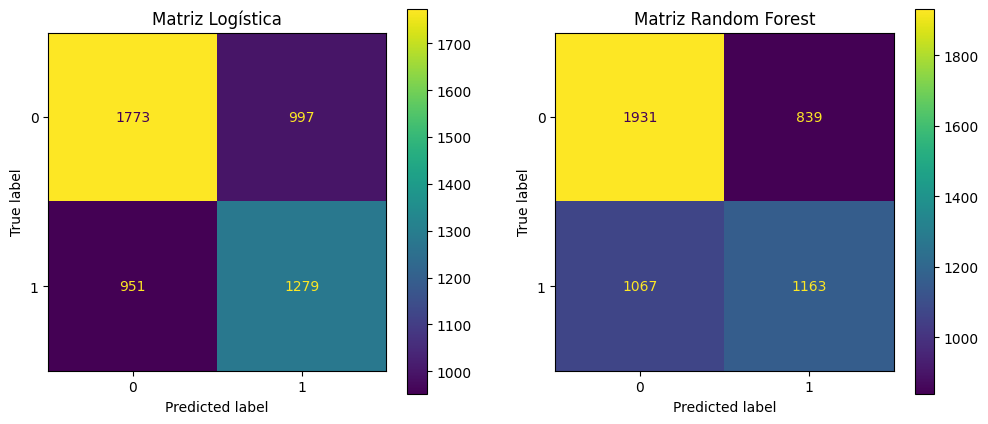

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax[0])
ax[0].set_title("Matriz Logística")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax[1])
ax[1].set_title("Matriz Random Forest")

plt.show()

## VALIDACIÓN CRUZADA

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

metrics = ['accuracy', 'precision', 'recall', 'f1']

# --- CROSS VALIDATION PARA LOGÍSTICA ---
cv_results_lr = cross_validate(pipeline_lr, X_train, y_train, cv=skf, scoring=metrics, n_jobs=-1)

# --- CROSS VALIDATION PARA RANDOM FOREST ---
cv_results_rf = cross_validate(pipeline_rf, X_train, y_train, cv=skf, scoring=metrics, n_jobs=-1)

def print_cv_results(name, results):
    print(f"\nResultados CV: {name}")
    print(f"  F1-Score:  {results['test_f1'].mean():.4f} (+/- {results['test_f1'].std():.4f})")
    print(f"  Recall:    {results['test_recall'].mean():.4f}")
    print(f"  Precision: {results['test_precision'].mean():.4f}")
    print(f"  Accuracy:  {results['test_accuracy'].mean():.4f}")

print_cv_results("LOGÍSTICA", cv_results_lr)
print_cv_results("RANDOM FOREST", cv_results_rf)


Resultados CV: LOGÍSTICA
  F1-Score:  0.5947 (+/- 0.0141)
  Recall:    0.5974
  Precision: 0.5921
  Accuracy:  0.6369

Resultados CV: RANDOM FOREST
  F1-Score:  0.5505 (+/- 0.0062)
  Recall:    0.5147
  Precision: 0.5918
  Accuracy:  0.6251


## OPTIMIZACIÓN DE HIPERPARAMETROS

In [ ]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [2, 5, 8],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt']
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=skf,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train, y_train)

print("Mejores parámetros:")
print(grid_rf.best_params_)

print(f"\nMejor F1 (CV): {grid_rf.best_score_:.4f}")

best_model = grid_rf.best_estimator_

y_pred = best_model.predict(X_test)

print("\nReporte de clasificación (TEST):")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores parámetros:
{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 100}

Mejor F1 (CV): 0.5939

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      2770
           1       0.57      0.55      0.56      2230

    accuracy                           0.62      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.62      0.62      0.62      5000



## OPTIMIZACIÓN DE TRESHOLD

In [ ]:
probs_train = best_model.predict_proba(X_train)[:, 1]

thresholds = np.linspace(0.1, 0.9, 50)
best_f1 = 0
best_thr = 0.5

for t in thresholds:
    score = f1_score(y_train, (probs_train >= t).astype(int))
    if score > best_f1:
        best_f1 = score
        best_thr = t

print(f"Mejor umbral: {best_thr:.4f}  |  F1: {best_f1:.4f}")

Mejor umbral: 0.4429  |  F1: 0.7121


In [ ]:
# Evaluación final
probs_test = best_model.predict_proba(X_test)[:, 1]
y_pred_opt = (probs_test >= best_thr).astype(int)

print("\nReporte de clasificación con threshold optimizado:")
print(classification_report(y_test, y_pred_opt))


Reporte de clasificación con threshold optimizado:
              precision    recall  f1-score   support

           0       0.69      0.49      0.58      2770
           1       0.54      0.72      0.61      2230

    accuracy                           0.60      5000
   macro avg       0.61      0.61      0.60      5000
weighted avg       0.62      0.60      0.59      5000



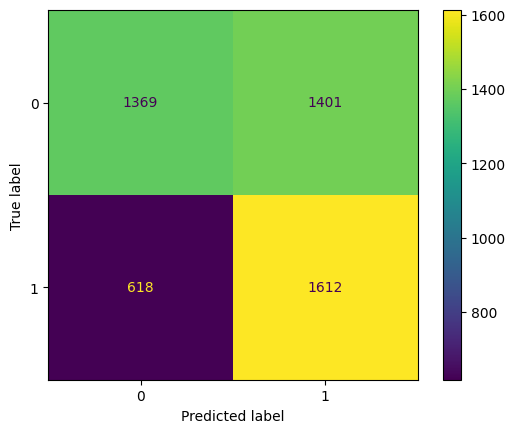

In [ ]:
# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt)

## EXPORTACIÓN

In [ ]:
!pip install skl2onnx

In [ ]:
import json
from skl2onnx import convert_sklearn, __max_supported_opset__
from skl2onnx.common.data_types import FloatTensorType, StringTensorType, Int64TensorType

initial_type = [
    ('Airline', StringTensorType([None, 1])),
    ('AirportFrom', FloatTensorType([None, 1])),
    ('AirportTo', FloatTensorType([None, 1])),
    ('DayOfWeek', Int64TensorType([None, 1])),
    ('Length', FloatTensorType([None, 1])),
    ('Hour', FloatTensorType([None, 1]))
]

onx = convert_sklearn(
    best_model,
    initial_types=initial_type,
    target_opset=__max_supported_opset__
)

onnx_path = "flight_delay_model.onnx"
with open(onnx_path, "wb") as f:
    f.write(onx.SerializeToString())
print(f"Modelo exportado: {onnx_path}")

threshold_path = "flight_delay_threshold.json"
threshold_info = {"best_threshold": best_thr}

with open(threshold_path, "w") as f:
    json.dump(threshold_info, f)

print(f"Threshold guardado: {threshold_path}  |  Valor: {best_thr:.4f}")

mappings = {
    "from_map": from_map,
    "to_map": to_map,
    "global_mean": float(global_mean)
}

with open("airport_mappings.json", "w") as f:
    json.dump(mappings, f)

Modelo exportado: flight_delay_model.onnx
Threshold guardado: flight_delay_threshold.json  |  Valor: 0.4429


```
from skl2onnx import InferenceSession
session = InferenceSession(onnx_path)
  with open(threshold_path) as f:
   threshold = json.load(f)['best_threshold']

X_input debe ser un diccionario tipo {columna: np.array([...])}
probs = session.run(None, X_input)[1][:,1]  # columna de probabilidad de clase 1
y_pred = (probs >= threshold).astype(int)
print("Predicciones finales con threshold aplicado:", y_pred)
```
> Ejemplo de inferencia

# Modelado de Datos 1

In [ ]:
# ==========================
# MODELADO + COMPARACIÓN (LR vs RF) + THRESHOLD OPTIMIZADO + EXPORT
# ==========================
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)



In [ ]:
# --------------------------
# 0) Config (ajustable)
# --------------------------
RANDOM_STATE = 42

# Para que corra rápido en notebook
N_SAMPLE_LR = 200000   # LR puede con más datos
N_SAMPLE_RF = 120000   # RF en muestra (evita que se quede colgado)

# Control de OneHot (evita explosión de columnas)
MIN_FREQ = 100
MAX_CATEGORIES = 200

# Threshold base (MVP)
BASE_THRESHOLD = 0.5



In [ ]:
# --------------------------
# 1) Preparación del dataframe
# --------------------------
df_model = df.copy()

# Asegurar drop de id si existe (en tu notebook ya lo hacen, pero acá queda robusto)
if "id" in df_model.columns:
    df_model.drop(columns=["id"], inplace=True)

# Quitar anomalías (en este dataset existen Length=0)
df_model = df_model[df_model["Length"] > 0].copy()

# Para MVP: Flight suele ser alta cardinalidad y puede ralentizar / sobreajustar
if "Flight" in df_model.columns:
    df_model.drop(columns=["Flight"], inplace=True)

# Asegurar target y features
if "Delay" not in df_model.columns:
    raise ValueError("No se encuentra la columna target 'Delay' en df_model.")

y_full = df_model["Delay"].astype(int)
X_full = df_model.drop(columns=["Delay"])

# Columnas categóricas y numéricas (incluye TimeDay/Duration si existen en tu notebook)
cat_cols = [c for c in ["Airline", "AirportFrom", "AirportTo", "TimeDay", "Duration"] if c in X_full.columns]
num_cols = [c for c in ["Time", "Length"] if c in X_full.columns]

print("Columnas categóricas:", cat_cols)
print("Columnas numéricas:", num_cols)
print("Filas totales para modelado:", len(df_model))


Columnas categóricas: ['Airline', 'AirportFrom', 'AirportTo', 'TimeDay', 'Duration']
Columnas numéricas: ['Time', 'Length']
Filas totales para modelado: 539379


> No se toma en cuenta como se van a tratar columnas como **AirportFrom** y **AirportTo**, ya que tienen demasiados valores para el OneHotEncoding. **TimeDay** y **Duration** provienen de **Time** y **Length** por lo que se esta dando la misma información.

In [ ]:
# --------------------------
# 2) Muestreo (para velocidad)
# --------------------------
if len(df_model) > N_SAMPLE_LR:
    df_lr = df_model.sample(n=N_SAMPLE_LR, random_state=RANDOM_STATE)
else:
    df_lr = df_model.copy()

if len(df_model) > N_SAMPLE_RF:
    df_rf = df_model.sample(n=N_SAMPLE_RF, random_state=RANDOM_STATE)
else:
    df_rf = df_model.copy()



In [ ]:
# --------------------------
# 3) Preprocesamiento
# --------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(
            handle_unknown="ignore",
            min_frequency=MIN_FREQ,
            max_categories=MAX_CATEGORIES,
            sparse_output=True
        ), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)



> Al manejar columnas con demasiados ouliers como **Length**, es preferible usar **RobustScaler()**, ya que usa la media y los IQR. Por lo que, no afectan el escalado de los valores a comparación de **StandarScaler()** que utiliza la media y la desviación estándar.

In [ ]:
# --------------------------
# 4) Modelos
# --------------------------
pipe_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=400,
        solver="saga",
        n_jobs=-1
    ))
])

pipe_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=150,
        max_depth=18,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])



In [ ]:
# --------------------------
# 5) Helpers de evaluación
# --------------------------
def eval_with_threshold(model, X_train, X_test, y_train, y_test, threshold=0.5):
    """Entrena model, predice y devuelve métricas a threshold dado."""
    model.fit(X_train, y_train)

    if not hasattr(model, "predict_proba"):
        y_pred = model.predict(X_test)
        return {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "roc_auc": np.nan,
            "threshold": np.nan
        }

    proba = model.predict_proba(X_test)[:, 1]
    y_pred = (proba >= threshold).astype(int)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, proba),
        "threshold": float(threshold)
    }

def find_best_threshold_for_f1(model, X_train, X_test, y_train, y_test, thresholds=None):
    """Entrena model y busca el threshold que maximiza F1."""
    if thresholds is None:
        thresholds = np.linspace(0.2, 0.8, 25)

    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]

    best = None
    for t in thresholds:
        pred = (proba >= t).astype(int)
        f1 = f1_score(y_test, pred, zero_division=0)
        p = precision_score(y_test, pred, zero_division=0)
        r = recall_score(y_test, pred, zero_division=0)
        a = accuracy_score(y_test, pred)
        row = {"threshold": float(t), "f1": f1, "precision": p, "recall": r, "accuracy": a}
        if best is None or row["f1"] > best["f1"]:
            best = row

    return best



In [ ]:
# --------------------------
# 6) Entrenar + evaluar Logistic Regression (threshold 0.5 + threshold óptimo F1)
# --------------------------
print("\n--- Entrenando Logistic Regression ---")
y_lr = df_lr["Delay"].astype(int)
X_lr = df_lr.drop(columns=["Delay"])

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y_lr, test_size=0.2, stratify=y_lr, random_state=RANDOM_STATE
)

lr_base = eval_with_threshold(pipe_lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr, threshold=BASE_THRESHOLD)
best_thr = find_best_threshold_for_f1(pipe_lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr)

# Re-evaluar LR con el mejor threshold encontrado
lr_best = eval_with_threshold(pipe_lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr, threshold=best_thr["threshold"])

print("LR listo. Best threshold (por F1):", best_thr["threshold"])




--- Entrenando Logistic Regression ---
LR listo. Best threshold (por F1): 0.32500000000000007


In [ ]:
# --------------------------
# 7) Entrenar + evaluar Random Forest (threshold 0.5)
# --------------------------
print("\n--- Entrenando Random Forest ---")
y_rf = df_rf["Delay"].astype(int)
X_rf = df_rf.drop(columns=["Delay"])

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, stratify=y_rf, random_state=RANDOM_STATE
)

rf_base = eval_with_threshold(pipe_rf, X_train_rf, X_test_rf, y_train_rf, y_test_rf, threshold=BASE_THRESHOLD)
print("RF listo.")




--- Entrenando Random Forest ---
RF listo.


In [ ]:
# --------------------------
# 8) Tabla final comparativa
# --------------------------
results = pd.DataFrame([
    {"model": "LogisticRegression (thr=0.5)", **lr_base, "train_rows": len(df_lr)},
    {"model": f"LogisticRegression (thr={lr_best['threshold']:.2f} best F1)", **lr_best, "train_rows": len(df_lr)},
    {"model": "RandomForest (thr=0.5)", **rf_base, "train_rows": len(df_rf)},
]).sort_values("f1", ascending=False)

results



,model,accuracy,precision,recall,f1,roc_auc,threshold,train_rows
1,LogisticRegression (thr=0.33 best F1),0.577650,0.516391,0.847830,0.641849,0.689397,0.325,200000
0,LogisticRegression (thr=0.5),0.642900,0.630471,0.483226,0.547115,0.689397,0.500,200000
2,RandomForest (thr=0.5),0.644792,0.696845,0.362559,0.476962,0.693145,0.500,120000


> El proceso de validación es muy débil, no se usó **StratifiedK-Fold**. Esto puede perjudicar las métricas de rendimiento y generar un falso desempeño. Además, la selección de hiperparámetros no se está tomando en cuenta.

In [ ]:
# --------------------------
# 9) Selección del modelo final + export
# --------------------------
# Regla simple: elegir el de mejor F1 en results
best_row = results.iloc[0]
best_model_name = best_row["model"]
print("\nMejor configuración por F1:", best_model_name)

# Si el mejor es LR, dejamos pipe_lr entrenado ya sobre el split de LR y exportamos.
# Si el mejor es RF, exportamos pipe_rf (entrenado en su split).
# if "RandomForest" in best_model_name:
#     final_model = pipe_rf
#     final_threshold = BASE_THRESHOLD
# else:
#     final_model = pipe_lr
#     final_threshold = float(best_row["threshold"]) if not pd.isna(best_row["threshold"]) else BASE_THRESHOLD

# joblib.dump({"model": final_model, "threshold": final_threshold}, "flight_delay_bundle.joblib")
# print("Exportado: flight_delay_bundle.joblib (incluye modelo + threshold)")






Mejor configuración por F1: LogisticRegression (thr=0.33 best F1)


In [ ]:
# ==========================
# 9.1) ENTRENAMIENTO FINAL LIMPIO (EL QUE SE EXPORTA)
# ==========================

# Usamos TODO df_model (no muestras)
y_final = df_model["Delay"].astype(int)
X_final = df_model.drop(columns=["Delay"])

final_pipeline = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=400,
        solver="saga",
        n_jobs=-1
    ))
])

final_pipeline.fit(X_final, y_final)


final_threshold = float(best_row["threshold"])

joblib.dump(
    {
        "model": final_pipeline,
        "threshold": final_threshold
    },
    "flight_delay_bundle.joblib"
)

print("📦 Exportado flight_delay_bundle.joblib")

# 🔍 VERIFICACIÓN CRÍTICA
X_check = final_pipeline.named_steps["prep"].transform(X_final.iloc[:1])
print("✅ Número final de features:", X_check.shape)




📦 Exportado flight_delay_bundle.joblib
✅ Número final de features: (1, 427)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# --------------------------
# 10) Función de inferencia para API (devuelve probabilidad + label)
# --------------------------
def predict_payload(payload_features: dict):
    """
    payload_features debe venir con keys como:
    Airline, AirportFrom, AirportTo, DayOfWeek, Time, Length
    (y TimeDay/Duration si tu modelo las usa y tu API las manda; si no, NO las incluyas).
    """
    bundle = joblib.load("flight_delay_bundle.joblib")
    model = bundle["model"]
    threshold = bundle["threshold"]

    X_one = pd.DataFrame([payload_features])
    prob = float(model.predict_proba(X_one)[0, 1])
    pred = int(prob >= threshold)
    return {"prevision": "Retrasado" if pred == 1 else "Puntual", "probabilidad": prob}

# Ejemplo rápido (ajusta valores)
# sample = {"Airline":"AA","AirportFrom":"SFO","AirportTo":"DFW","DayOfWeek":3,"Time":900,"Length":180}
# predict_payload(sample)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Asegúrate de que existen (del bloque de LR):
# pipe_lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr

In [ ]:
# 1) Entrenar y obtener probas
pipe_lr.fit(X_train_lr, y_train_lr)
proba = pipe_lr.predict_proba(X_test_lr)[:, 1]

In [ ]:
# 2) Función para graficar la matriz de confusión según threshold (sin figura extra)
def plot_confusion_for_threshold(y_true, proba, threshold, title_prefix="LogisticRegression"):
    y_pred = (proba >= threshold).astype(int)

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Puntual (0)", "Retrasado (1)"],
        values_format="d"
    )
    disp.ax_.set_title(f"{title_prefix} - Confusion Matrix (threshold={threshold})")
    disp.ax_.set_xlabel("Predicción")
    disp.ax_.set_ylabel("Real")
    plt.show()

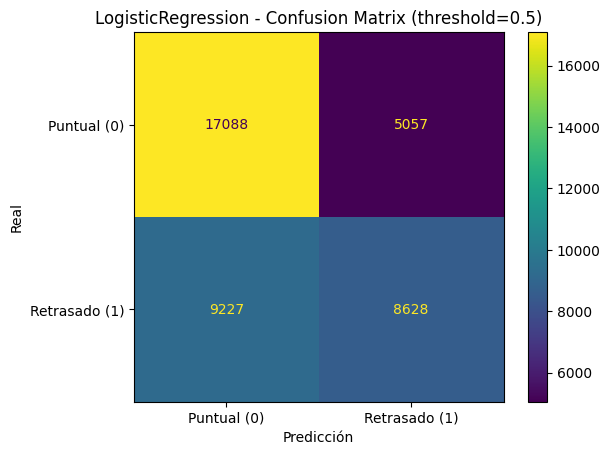

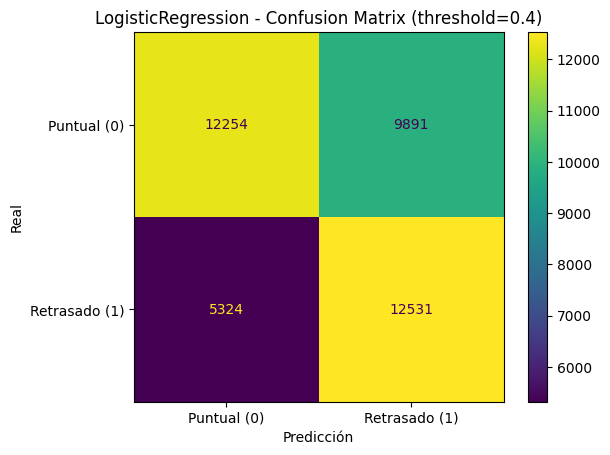

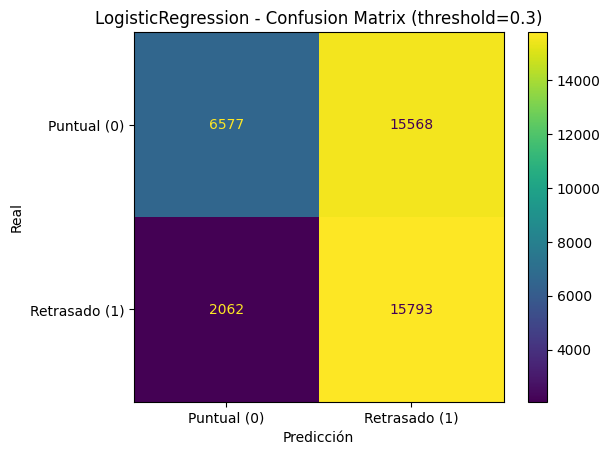

In [ ]:
# 3) Graficar para thresholds 0.5 y 0.3
plot_confusion_for_threshold(y_test_lr, proba, 0.5)
plot_confusion_for_threshold(y_test_lr, proba, 0.4)
plot_confusion_for_threshold(y_test_lr, proba, 0.3)

## 📄 Informe Final del Modelado

Este informe documenta el proceso de modelado predictivo para la detección de retrasos en vuelos, desde la preparación de los datos hasta la selección y exportación del modelo final.

### 1. Introducción y Objetivos
*   Breve resumen del problema de negocio y el objetivo del modelado (predecir retrasos en vuelos).
*   Contexto del dataset y las variables disponibles.

### 2. Preparación de Datos para el Modelado
*   **Eliminación de Columnas:** Detalles sobre las columnas eliminadas (`id`, `Flight`, `Time`, etc.) y la justificación.
*   **Manejo de Valores Atípicos/Anomalías:** Explicación de la limpieza de `Length = 0`.
*   **Agrupación de Categorías:** Descripción de cómo se agruparon las aerolíneas (`OTHERS`).
*   **Ingeniería de Características:** Explicación de la creación de `Hour`, `TimeDay`, `Duration` y la codificación de media (`AirportFrom`, `AirportTo`).
*   **División del Dataset:** Detalles sobre la división en conjuntos de entrenamiento y prueba (proporción, `random_state`, `stratify`).

### 3. Preprocesamiento de Variables
*   **Transformaciones Numéricas:** Uso de `RobustScaler` o `StandardScaler` para las variables numéricas (`Length`, `Hour`).
*   **Codificación Categórica:** Uso de `OneHotEncoder` para variables como `Airline` y `DayOfWeek`, incluyendo parámetros como `min_frequency` y `max_categories`.
*   **Uso de `ColumnTransformer` y `Pipeline`:** Explicación de cómo se estructuró el preprocesamiento.

### 4. Modelado y Entrenamiento
*   **Modelos Evaluados:** Descripción de los modelos utilizados (e.g., Regresión Logística, Random Forest).
*   **Parámetros Iniciales:** Configuración de los hiperparámetros base de cada modelo (e.g., `class_weight='balanced'`, `max_iter`).
*   **Muestreo:** Justificación del muestreo del dataset para la fase inicial de entrenamiento y evaluación.

### 5. Evaluación de Modelos (Base)
*   **Métricas Utilizadas:** Explicación de las métricas clave (F1-score, Recall, Precision, Accuracy) y por qué F1 es relevante para este problema.
*   **Resultados Iniciales:** Comparación de los resultados de Regresión Logística y Random Forest con un umbral base (0.5).

### 6. Optimización del Modelo
*   **Validación Cruzada:** Descripción del proceso de validación cruzada (`StratifiedKFold`) y sus resultados.
*   **Optimización de Hiperparámetros (`GridSearchCV`):** Detalles sobre la búsqueda de los mejores hiperparámetros para el modelo seleccionado (e.g., para Random Forest: `n_estimators`, `max_depth`, etc.).
*   **Optimización del Umbral (Threshold):** Explicación del proceso para encontrar el umbral óptimo que maximiza el F1-score en el conjunto de entrenamiento/validación.
*   **Resultados con Modelo Optimizado y Umbral:** Presentación de las métricas finales en el conjunto de prueba con el modelo y umbral seleccionados.

### 7. Selección del Modelo Final y Conclusiones
*   Justificación de la elección del modelo final (e.g., por su rendimiento en F1-score, interpretabilidad, velocidad, etc.).
*   Principales hallazgos del modelado.
*   Limitaciones del modelo actual y posibles mejoras futuras.

### 8. Exportación y Documentación para Integración
*   **Modelo:** Descripción de cómo se exportó el modelo (e.g., `skl2onnx` para ONNX, `joblib` para el pipeline completo).
*   **Umbral:** Detalle de cómo se guardó el umbral optimizado (`JSON`).
*   **Mapeos:** Documentación de los mapeos para `AirportFrom` y `AirportTo` (`JSON`).
*   **Instrucciones de Carga e Inferencia (`ONNX`):** Provisión de un código de ejemplo claro para cargar el modelo ONNX, el umbral y los mapeos, y realizar una inferencia con nuevos datos. Incluir la estructura esperada de los datos de entrada (`X_input`).
